# 2. 생활인구 데이터 분석
### 2-1. 데이터 가져오기 및 데이터 전처리
### 2-2. 생활인구를 분석하기 위한 Pivot Table 생성
### 2-3. 생활인구를 일별, 주별, 월별로 시각화
### 2-4. (주)에스나인에스의 행정동 데이터를 가져와 KT의 생활인구 데이터와 병합
### 2-5. 생활인구를 서울시 자치구별로 구분
### 2-6. 생활인구 지도 시각화
### 2-7. 자치구별 생활인구를 월별로 비교

## 2-1. 데이터 가져오기 및 데이터 전처리

In [310]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib
import matplotlib.pyplot as plt
import matplotlib.font_manager as fm

matplotlib.rcParams['axes.unicode_minus'] = False
matplotlib.rc('font', family='Malgun Gothic')

import warnings
warnings.filterwarnings('ignore')

df = pd.read_csv('popl.csv', encoding='utf-8')

cond = df['sexdstn_se_code'] == '-'                     # 성별 데이터 중 '-'의 값을 가지는 행을 모두 제외한 df 생성
df = df.loc[~cond]                                  

df.drop(['fore_pop_1'], axis=1, inplace=True)           # 외국인 생활인구수는 0으로 모두 분석에서 제외
df.drop(['fore_pop_2'], axis=1, inplace=True)
df.columns = ['날짜', '시간대', '성별', '연령대', '행정동코드', '내국인 인구수']

df['날짜'] = df['날짜'].astype(str)                      # 날짜를 datetime으로 바꿔줌 
df['date']= pd.to_datetime(df['날짜'])
df.drop(['날짜'], axis=1, inplace=True)
df = df.sort_values(by='date', ascending=True)

## 2-2. 생활인구를 분석하기 위한 Pivot Table 생성

In [311]:
date_pv = df.pivot_table(index='date', values='내국인 인구수', aggfunc='sum')
date_pv['내국인 인구수'] = date_pv['내국인 인구수'] / 10000                        # 일별로 생활인구를 시각화하기 위한 pivot table 생성

df['월'] = df['date'].dt.month
df['주차'] = df['date'].dt.week
df['일'] = df['date'].dt.day
df['요일'] = df['date'].dt.day_name()

date_pv_week = df.pivot_table(index='주차', values='내국인 인구수', aggfunc='sum')       # 주별로 시각화하기 위한 pivot table 생성
date_pv_week['내국인 인구수'] = date_pv_week['내국인 인구수'] / 10000

date_pv_month = df.pivot_table(index='월', values='내국인 인구수', aggfunc='sum')        # 월별로 시각화하기 위한 pivot table 생성
date_pv_month['내국인 인구수'] = date_pv_month['내국인 인구수'] / 10000

## 2-3. 생활인구를 일별, 주별, 월별로 시각화

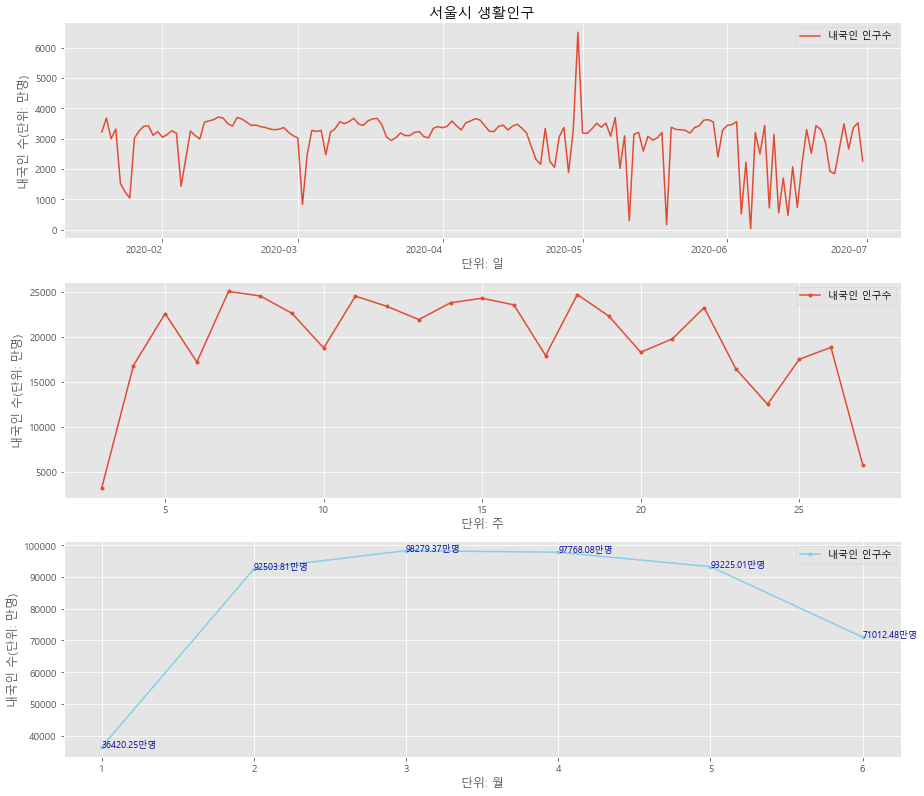

In [312]:
plt.style.use('ggplot')
f, ax = plt.subplots(3, 1, figsize=(15, 15))
date_pv.plot(kind='line', rot=0, ax=ax[0])
ax[0].set_title('서울시 생활인구')
ax[0].set_ylabel('내국인 수(단위: 만명)')
ax[0].set_xlabel('단위: 일')

date_pv_week.plot(kind='line', marker='.', ax=ax[1]) 
ax[1].set_ylabel('내국인 수(단위: 만명)')
ax[1].set_xlabel('단위: 주')

date_pv_month.plot(kind='line', color='skyblue', marker='.', ax=ax[2])
for i, value in enumerate(date_pv_month['내국인 인구수']):
    ax[2].text(i+1, value,
            '%s만명' % round(value, 2),
            fontsize=9, color='#000099',
            horizontalalignment='left',
            verticalalignment='baseline')
ax[2].set_ylabel('내국인 수(단위: 만명)')
ax[2].set_xlabel('단위: 월')

plt.show() 

* 1월의 데이터가 19일부터 31일까지만 존재하고, 생활인구 데이터가 전혀 존재하지 않았던 행정동도 있었습니다.
* 특정 날(구정 1월 24일, 석가탄신일 4월 30일)에 생활인구가 대폭 증감하는 것을 확인할 수 있었습니다.
* 이런 이유로 일별로 시각화하여 데이터를 분석하기 보다는 생활인구의 추이를 확인하는 것에 포커스를 맞추고 보다 큰 단위인 주별과 월별로 시각화했습니다.
* **코로나19** 이후 생활인구가 점차 감소하는 것을 확인했고, 코로나 확진자가 가장 많았던 **5월과 6월까지** 생활인구가 대폭 감소한 것을 확인했습니다.


## 2-4.  (주)에스나인에스의 행정동 데이터를 가져와 KT의 생활인구 데이터와 병합
####    - 생활인구데이터에는 행정시, 구, 동명이 존재하지 않기 때문에 이를 매핑해주는 작업이 필요했습니다.  

In [313]:
code_map = pd.read_csv('행정동_2021.csv', encoding='utf-8')
code_map.drop(['생성일자','말소일자'], axis=1, inplace=True)
code_map.columns = ['행정동코드', '시도', '시군구', '읍면동']
code_map['행정동코드'] = code_map['행정동코드'].astype(str)
code_map['행정동코드'] = code_map['행정동코드'].str[:-2]
cond = code_map['읍면동'].isnull()
code_map = code_map[~cond]

df['행정동코드'] = df['행정동코드'].astype(str)
df_mer = pd.merge(df, code_map, on='행정동코드', how='inner')

MemoryError: Unable to allocate 925. MiB for an array with shape (5, 24248456) and data type int64

## 2-5. 생활인구를 서울시 **자치구별**로 구분
#### 1) 어떤 자치구에 생활인구가 가장 많고 적을까?
#### 2) 자치구별로 남녀의 생활인구는 어떤 차이가 있을까? 

In [ ]:
df_area = df_mer.pivot_table(index='시군구', values='내국인 인구수', aggfunc='sum')
df_area['내국인 인구수'] = df_area['내국인 인구수'] /10000
df_area = df_area.sort_values(by='내국인 인구수', ascending=True)

df_area_gen = df_mer.pivot_table(index='시군구', values='내국인 인구수', columns='성별',aggfunc='sum')
df_area_gen['합계'] = df_area_gen['F'] + df_area_gen['M']
df_area_gen = df_area_gen.sort_values(by='합계', ascending=True)
df_area_gen['F']  = df_area_gen['F'] / 10000
df_area_gen['M']  = df_area_gen['M'] / 10000 

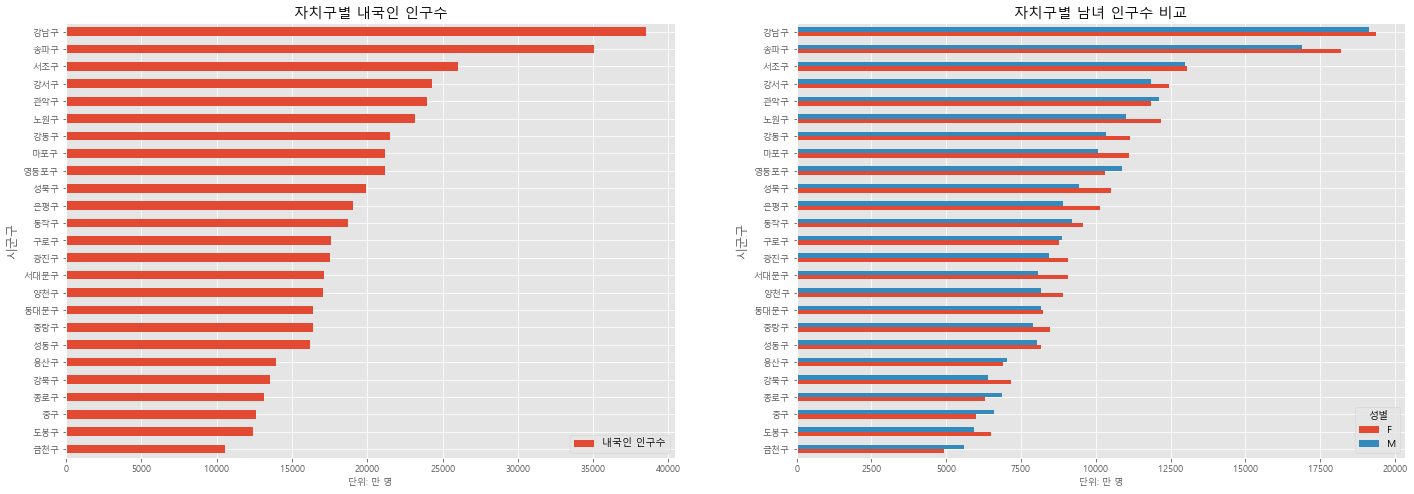

In [ ]:
f, ax = plt.subplots(1, 2, figsize=(24, 8))
df_area.plot(kind='barh',rot=0, fontsize=9, ax=ax[0])
ax[0].set_title('자치구별 내국인 인구수')
ax[0].set_xlabel('단위: 만 명', fontsize=9)

df_area_gen.plot(kind='barh', y=['F','M'], rot=0, fontsize=9, ax=ax[1])
ax[1].set_title('자치구별 남녀 인구수 비교')
ax[1].set_xlabel('단위: 만 명', fontsize=9)

plt.show()

* 강남구와 송파구의 생활인구가 월등히 많았고, 금천구가 가장 적은 것을 확인했습니다.
* 비교적 여성의 생활인구가 남성보다 높았고 특정 구(관악구, 영등포구 등)에서는 남성의 생활인구가 높은 것을 알 수 있었습니다.

## 2-6. 생활인구 지도 시각화
#### - folium 라이브러리와 json파일 이용 

In [ ]:
import json
import folium
geo_path = 'folium_seoul.json'
geo_str = json.load(open(geo_path, encoding='utf-8'))

from sklearn import preprocessing
df_area_norm = df_area.copy()
a = df_area_norm['내국인 인구수'].values
min_max_scaler = preprocessing.MinMaxScaler()
b = a.reshape(-1,1) #1차원 배열을 2차원 배열로 바꿔줌
b_scaled = min_max_scaler.fit_transform(b.astype(float))
df_area_norm.loc[:,'내국인 인구수'] = b_scaled

m = folium.Map(
    location=[37.5502, 126.982],
    zoom_start=11,
    tiles='Stamen Toner')
folium.Choropleth(
    geo_data=geo_str,
    data=df_area_norm['내국인 인구수'],
    columns=[df_area_norm.index,df_area_norm['내국인 인구수']],
    fill_color='YlGnBu', #PuRd, YlGnBu, YlGn, YlOrRd

    key_on='feature.id',
    legend_name='정규화된 생활인구비').add_to(m)
m

* 분석결과, 강남지역이이 강북지역보다 생활인구가 많은 것을 확인했습니다.
* 도심생활권인 용산, 중구, 종로구 / 서남2생활권인 금천 / 동북2생활권인 강북, 도봉의 생활인구가 다른 지역보다 훨씬 적었습니다. 

## 2-7. 자치구별 생활인구를 월별로 비교
#### - scikit-learn의 MinMaxScaler를 이용하여 편차가 큰 데이터들을 정규화
#### - 각 월에서 생활인구가 가장 많은 자치구를 Max(1), 적은 자치구를 Min(0)으로 설정하고 나머지 자치구의 데이터들을 0과 1사이의 수치로 표현
#### - 1월은 데이터가 너무 적기 때문에 분석에서 제외 

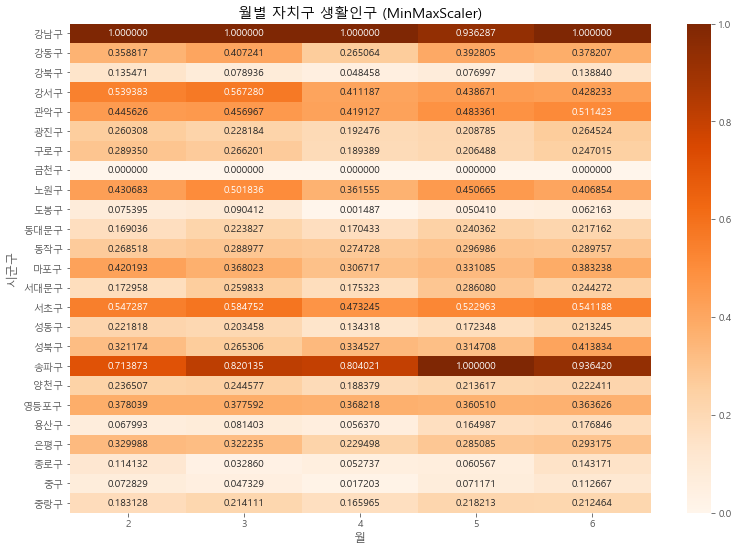

In [ ]:
df_month_area = df_mer.pivot_table(index='시군구', values='내국인 인구수', columns='월', aggfunc='sum')

df_month_area.drop([1], axis=1, inplace=True)
df_month_area_norm = df_month_area.copy()
columns = df_month_area_norm.columns.tolist()
x = df_month_area_norm[columns].values
min_max_scaler = preprocessing.MinMaxScaler()
x_scaled = min_max_scaler.fit_transform(x.astype(float))
df_month_area_norm.loc[:, columns] = x_scaled

plt.figure(figsize=(13, 9))
sns.heatmap(df_month_area_norm, annot=True, fmt='f', cmap='Oranges')
plt.title('월별 자치구 생활인구 (MinMaxScaler)')
plt.show()

* 2월부터 6월까지 강남구와 송파구의 생활인구 수가 부동의 1, 2위였습니다.
* 금천구는 2월부터 6월까지 가장 생황인구가 적었습니다(자치구별 배달순위는 2위).
* 배달이 많은 순으로 상위 5위였던 구로구, 금천구, 영등포구, 도봉구, 은평구는 다른 자치구보다 생활인구가 적었던 것을 확인할 수 있었습니다.

#### - 특정 자치구에서 배달 비율이 높은 상위 30위의 업체를 분석(특정 구 전체 배달 비율 중 44%의 데이터)
#### - 상위 30위의 업체를 기준으로 배달 품목의 비율을 분석  

In [ ]:
df2 = pd.read_csv('주문이 완료된 데이터.csv', encoding='cp949')

dlv_main = df2[['PROCESS_DT','SN', 'DLVR_STORE_ID', 'DLVR_STORE_INDUTY_NM', 'DLVR_DSTN_ADSTRD_CODE', 'GOODS_AMOUNT', 'SETLE_KND_VALUE']]
dlv_main.columns = ['date', '순번', '배달상점ID', '업종명', '행정동코드','배달상품금액','결제']
dlv_main['date'] = dlv_main['date'].astype(str)
dlv_main['date'] = pd.to_datetime(dlv_main['date'])
dlv_main['행정동코드'] = dlv_main['행정동코드'].astype(str)
dlv_main['행정동코드'] = dlv_main['행정동코드'].str[:-2]

code_map = pd.read_csv('행정동_2021.csv', encoding='utf-8')
code_map.drop(['생성일자','말소일자'], axis=1, inplace=True)
code_map.columns = ['행정동코드', '시도', '시군구', '읍면동']
code_map['행정동코드'] = code_map['행정동코드'].astype(str)
code_map['행정동코드'] = code_map['행정동코드'].str[:-2]
cond = code_map['읍면동'].isnull()
code_map = code_map[~cond]

dlv_main = pd.merge(dlv_main, code_map, on='행정동코드', how='inner')

In [ ]:
cond1 = dlv_main['시도'] == '서울특별시'
dlv_main = dlv_main.loc[cond1]

dlv_main['date'] = pd.to_datetime(dlv_main['date'])
cond2 = dlv_main['date'] >= '2020-05-01'
dlv_may = dlv_main.loc[cond2]

dlv_id = dlv_may.pivot_table(index='배달상점ID', values='순번', columns='시군구', aggfunc='count')

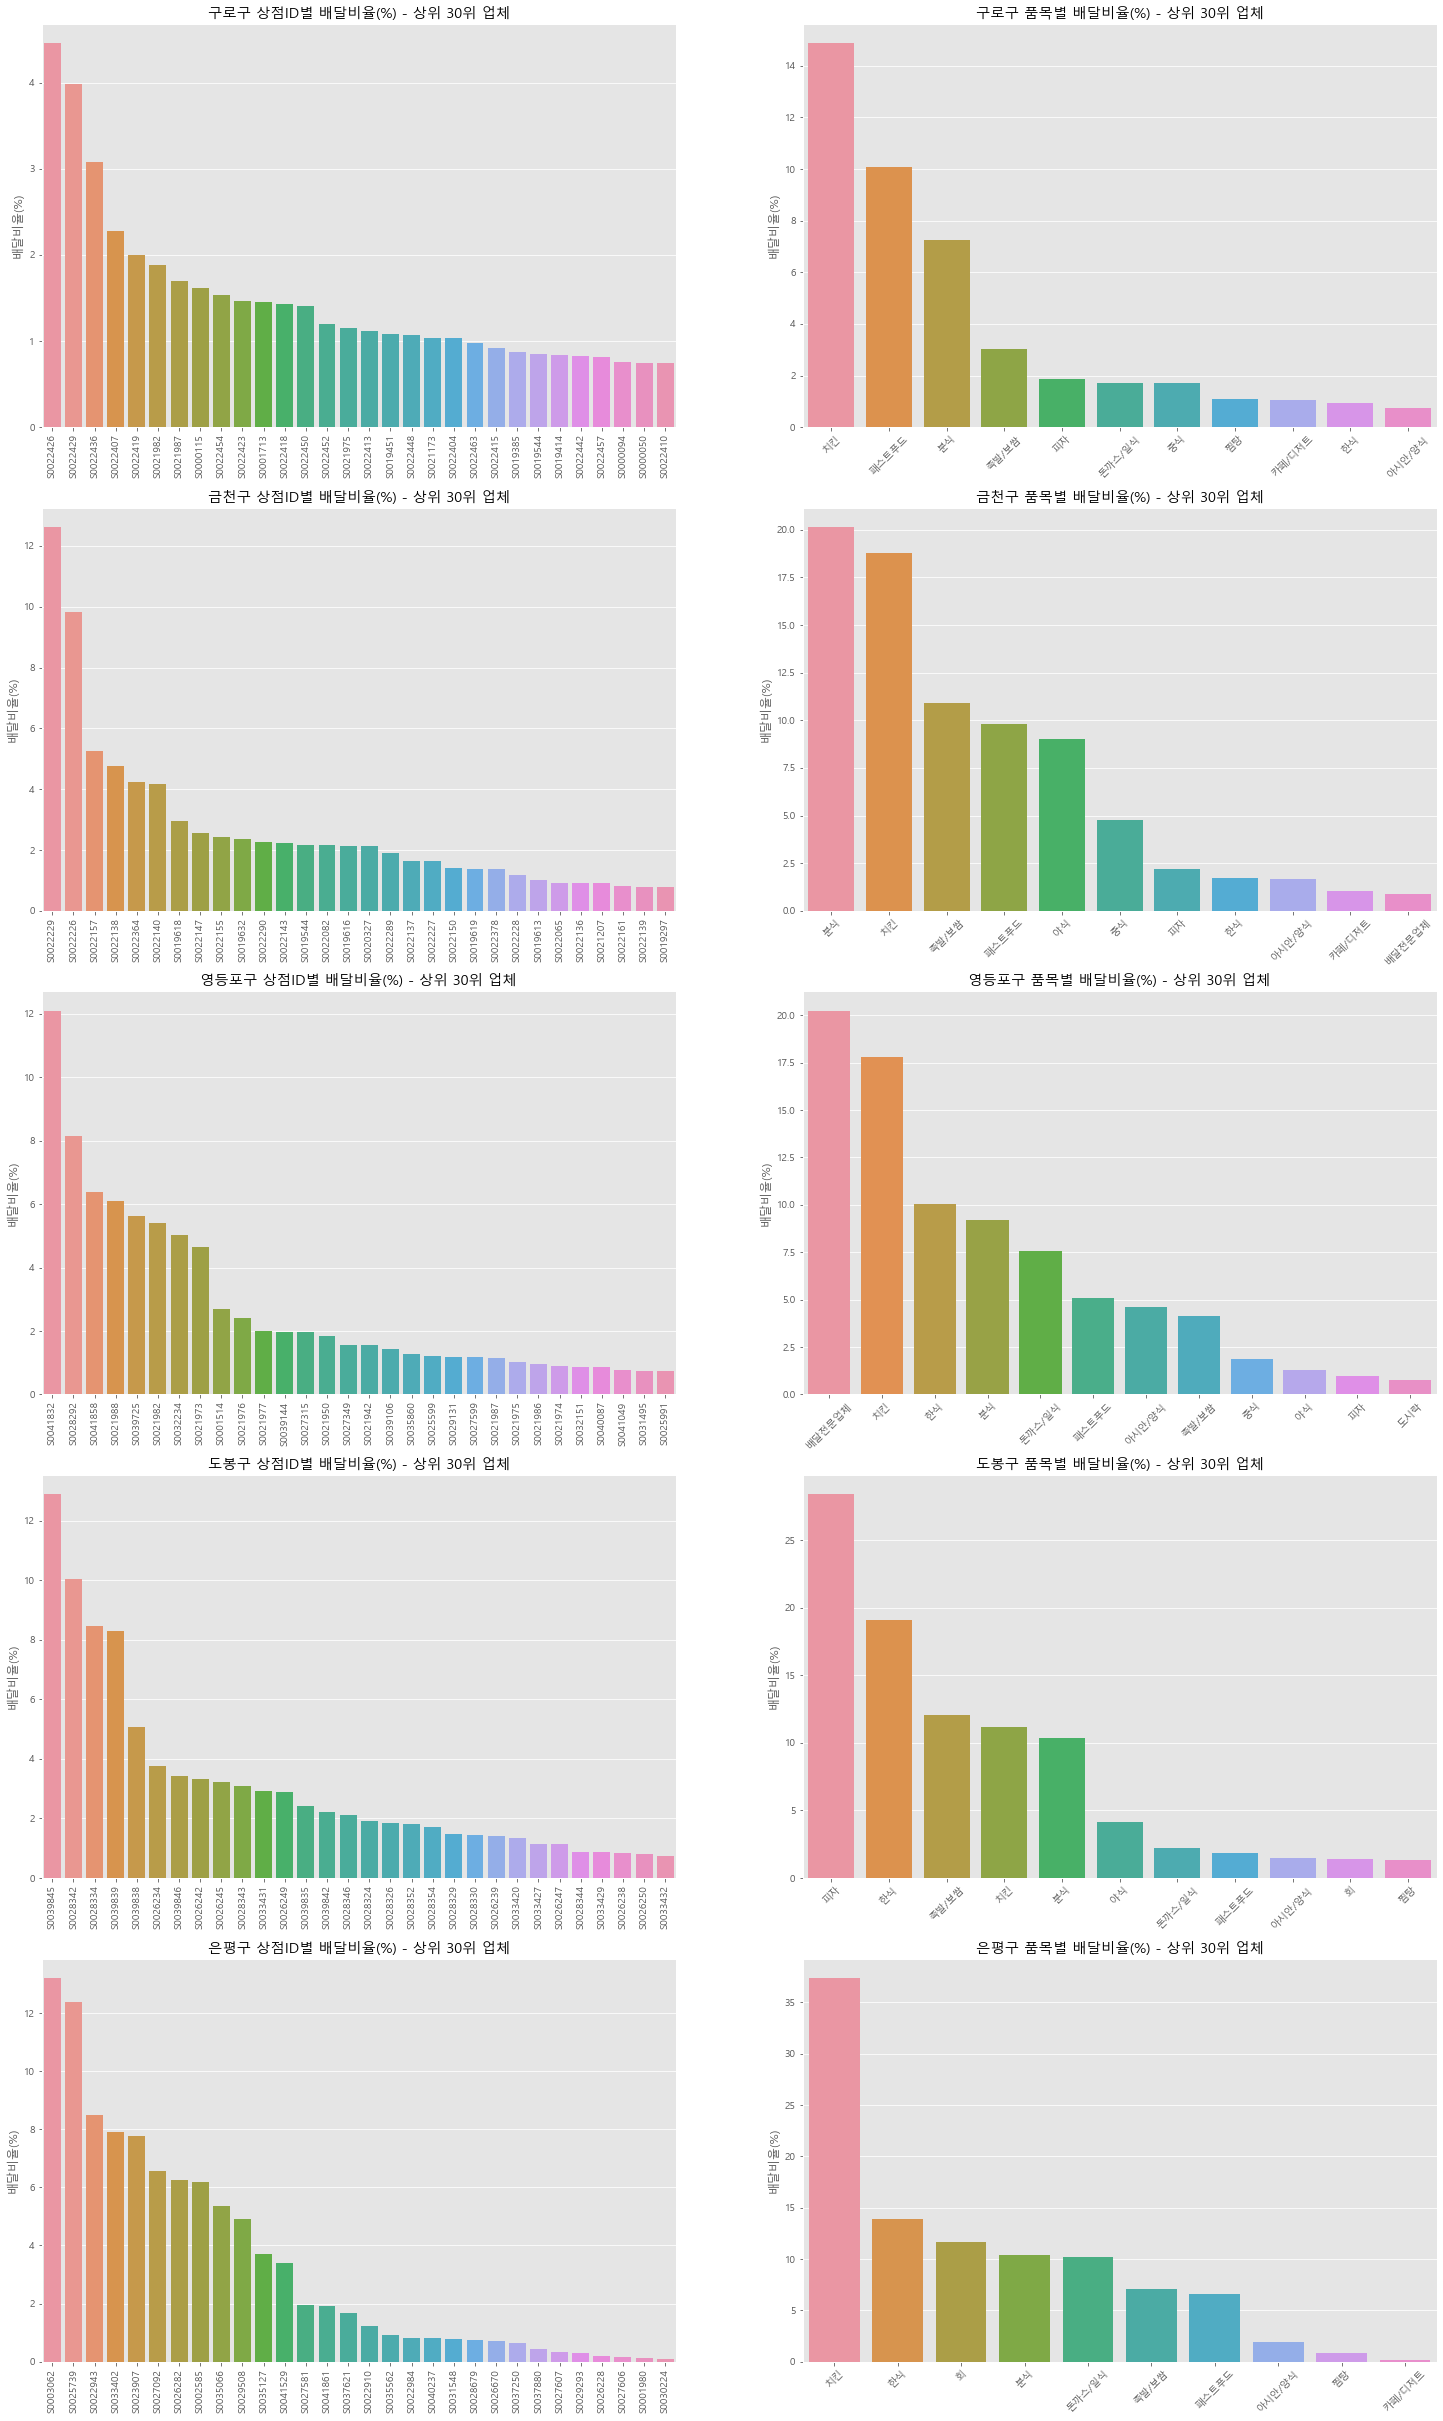

In [ ]:
gu_list = ['구로구', '금천구', '영등포구', '도봉구', '은평구']
f, ax = plt.subplots(5, 2, figsize=(25, 43))

for i in range(5):
    df_gu = dlv_id[[gu_list[i]]]
    total = int(df_gu[gu_list[i]].sum())
    df_gu['배달건수 비율'] = df_gu[gu_list[i]] / total * 100
    gu_id_rate = df_gu.sort_values(by=gu_list[i], ascending=False).head(30)

    top_30_index  = gu_id_rate.index
    top_30_list = top_30_index.tolist()
    y = []
    for j in range(1,31):
        y.append(j)

    y = pd.DataFrame(y)
    row = 0
    col = 1
    for k in top_30_list:
        cond = dlv_may['배달상점ID'] == k
        x = dlv_may.loc[cond][['업종명']]
        y[row:col] = x[0:1]
        row += 1
        col += 1

    y.columns = ['업종명']
    gu_id_rate['업종명'] = y['업종명']
    
    for l in range(30):
        gu_id_rate.iloc[l, 2] = y.iloc[l,0]
    
    gu_rate_nm = gu_id_rate
    nm_rate = gu_rate_nm.pivot_table(index='업종명', values='배달건수 비율', aggfunc='sum')
    top_30_nm = nm_rate.sort_values(by='배달건수 비율', ascending=False)

    sns.barplot(data=gu_id_rate, x=gu_id_rate.index, y='배달건수 비율', ax=ax[i,0])
    ax[i,0].set_title('{} 상점ID별 배달비율(%) - 상위 30위 업체'.format(gu_list[i]))
    ax[i,0].set_xlabel("")
    ax[i,0].set_ylabel("배달비율(%)")
    ax[i,0].set_xticklabels(gu_id_rate.index, rotation=90)
     
    sns.barplot(data=top_30_nm, x=top_30_nm.index, y='배달건수 비율', ax=ax[i,1])
    ax[i,1].set_title('{} 업종명별 배달비율(%) - 상위 30위 업체'.format(gu_list[i]))
    ax[i,1].set_xlabel("")
    ax[i,1].set_ylabel("배달비율(%)")
    ax[i,1].set_xticklabels(top_30_nm.index, rotation=45)

    

* 배달 수가 가장 많았던 구로구의 경우, 업체 순위가 S0022426(패스트 푸드) > S0022429(패스트 푸드) > S0022436(분식) > S0022407(치킨) 순으로 나타났지만, 상위 30위 업체의 데이터 기준으로 업종별 비율을    
  분석해보니 치킨 > 패스트푸드 > 분식 > 족발/보쌈 순으로 순위가 바뀐 것을 확인했습니다.
* 다른 자치구도 분석해 본 결과, 같은 양상을 보였습니다. 금천구의 경우 업체 순위가 S0022229(분식) > S0022226(패스트푸드) > S0022157(야식) > S0022138(중식) > S0022364(치킨) 순으로 나왔고 
  업종별 순위는 분식 > 치킨 > 족발/보쌈 > 패스트푸드 > 야식 순으로 나왔습니다. 패스트푸드 업체가 업체 2위를 했지만 업종별 비율에서는 패스트푸드가 4위가 되었고, 치킨을 파는 업체가 업체 순위에서 5위였지만 업종별 순위에서는 치킨의 배달 비율이 2위가 됐습니다.
* 영등포구의 경우 업체 랭킹 5위가 S0041832(배달전문업체) > S0028292(배달전문업체) > S0041858(돈까스) > S0021988(치킨) > S0039725(한식) 순으로 나왔고 업체별 순위는 배달전문업체 > 치킨 > 한식 > 분식 >
  돈까스/일식 순으로 나타났습니다. 위와 마찬가지로 돈까스를 파는 업체가 세 번째로 배달 비율이 높더라도 전체 업종별 품목에서는 돈까스/일식이 5위로 바뀐 것을 확인할 수 있었습니다. 
* 이는 특정 업체의 배달 순위가 높더라도 그 업체가 파는 음식(ex. 패스트푸드)의 업종별 배달비율이 다른 음식의 배달 비율보다 적을 수 있다는 것을 뜻합니다.
* 결론적으로 치킨을 파는 어떤 업체의 순위가 가장 높지 않더라도(구로구 4위), 치킨을 파는 ***업체 수***가 많으면 해당 자치구에서 치킨의 배달 비율(업종별 배달비율-구로구 1위)이 가장 높게 나타날 수 있습니다.
* 위 분석결과로 저희팀은 각 배달 품목의 **업체 수**가 중요하다고 생각했고, 경쟁사가 적으면서도 배달 비율이 높은 업종(음식)을 알아보기 위한 분석을 해봤습니다.

In [ ]:
# f, ax = plt.subplots(2, 3, figsize=(25, 15))
# r = 0
# c = 0
# for i in range(5):
#     df_gu = dlv_id[[gu_list[i]]]
#     total = int(df_gu[gu_list[i]].sum())
#     df_gu['배달건수 비율'] = df_gu[gu_list[i]] / total * 100
#     gu_id_rate = df_gu.sort_values(by=gu_list[i], ascending=False)

#     total_index  = gu_id_rate.index
#     total_list = total_index.tolist()
#     y = []
#     for j in range(1,789):
#         y.append(j)

#     y = pd.DataFrame(y)
#     row = 0
#     col = 1
#     for k in total_list:
#         cond = dlv_may['배달상점ID'] == k
#         x = dlv_may.loc[cond][['업종명']]
#         y[row:col] = x[0:1]
#         row += 1
#         col += 1

#     y.columns = ['업종명']
#     gu_id_rate['업종명'] = y['업종명']
    
#     for l in range(788):
#         gu_id_rate.iloc[l, 2] = y.iloc[l,0]
    
#     gu_rate_nm = gu_id_rate
#     nm_rate = gu_rate_nm.pivot_table(index='업종명', values='배달건수 비율', aggfunc='sum')
#     total_nm = nm_rate.sort_values(by='배달건수 비율', ascending=False)
    
#     if i == 3:
#         r = 1
#         c = 0
        
#     sns.barplot(data=total_nm, x=total_nm.index, y='배달건수 비율', ax=ax[r,c])
#     ax[r,c].set_title('{} 품목별 배달비율(%) - Total Data'.format(gu_list[i]))
#     ax[r,c].set_xlabel("")
#     ax[r,c].set_xticklabels(total_nm.index, rotation=50)
#     c += 1
# f.delaxes(ax[1,2])
